# A neural hidden Markov model: capture-recapture example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

## Generate a function that relates a covariate to survival and detection probabilities

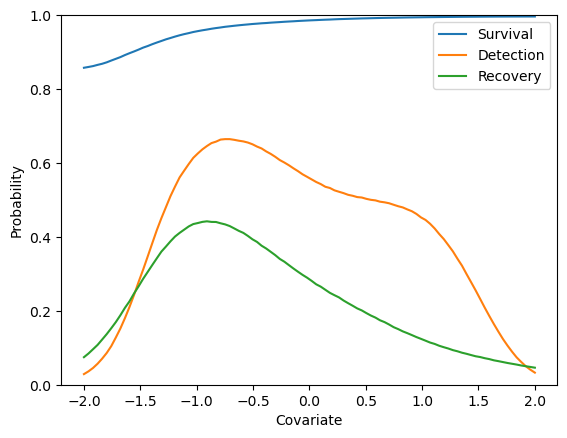

In [2]:
np.random.seed(12345)
nx = 100
x = np.linspace(-2, 2, nx, dtype=np.float32).reshape(-1,1)

def kernel(x, theta):
    m, n = np.meshgrid(x, x)
    sqdist = abs(m-n)**2
    return np.exp(- theta * sqdist)

def sigmoid(x, derivative=False):
    return 1. / (1. + np.exp(-x))

K = kernel(x, theta=.5)
jitter = 1e-5* np.eye(nx)
L = np.linalg.cholesky(K + jitter)
zvals = np.random.normal(size=(nx, 3))

f_survival = sigmoid(np.dot(L, zvals[:, 0]) + x[:, 0] + 4)
f_detection = sigmoid(np.dot(L, zvals[:, 1]) - x[:, 0]**2)
f_recovery = sigmoid(np.dot(L, zvals[:, 2]) - .5*x[:, 0]**2)

plt.plot(x, f_survival)
plt.plot(x, f_detection)
plt.plot(x, f_recovery)
plt.legend(['Survival', 'Detection', 'Recovery'])
plt.xlabel('Covariate')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.show()

In [3]:
x.shape

(100, 1)

In [4]:
f_survival.shape

(100,)

## Model formulation

Our model formulation is similar to the first simple case described in https://projecteuclid.org/euclid.aoas/1380804813

We assume that all individuals are initially captured, marked, and released on timestep $t=0$. The state of an individual on time step $t$ is denoted $z_{t}$. Individuals are either alive ($z_{t} = 0$), recently dead such that their bodies are discoverable and marks identifiable ($z_{t} = 1$), or long dead such that their bodies are not discoverable and/or marks are no longer identifiable ($z_t = 2$). The survival probability is denoted $\phi_t$, where $\phi_t = P(z_{t + 1} = 0 \mid z_{t} = 0)$. 

Observations $y_{t}$ are made on time steps $t=1, ..., T$, and if an individual is detected alive on timestep $t$, $y_{t} = 1$, and if an individual is detected as recently dead $y_t=2$, otherwise if the individual is not detected $y_{t} = 0$. 

At time $t$, the transition probability matrix $\pmb{\Gamma}_t$ contains the probability of transitioning from row $i$ to column $j$:

$$\pmb{\Gamma}_t = 
\begin{bmatrix}
    \phi_t  & 1 - \phi_t & 0 \\
    0       & 0          & 1 \\
    0       & 0          & 1
\end{bmatrix}.
$$

Let $\pmb{\Omega}_t$ denote an emission matrix containing state-dependent observation probabilities:

$$
\pmb{\Omega}_t =
\begin{bmatrix}
    1-p_t         & p_t & 0         \\
    1 - \lambda_t & 0   & \lambda_t \\
    1             &  0  & 0
\end{bmatrix},
$$

where $p_t$ is the probability of detecting an individual on timestep $t$, conditional on the individual being alive, and $\lambda_t$ is the probability of recovering a recently dead individual on timestep $t$ that has died since timestep $t-1$. 
The rows of the emission matrix correspond to states (alive, recently dead, long dead), and the columns correspond to observations (not detected, detected alive, detected dead).

In [5]:
# States are alive (0), recently dead (1), long dead (2)
n_state = 3

# Set up simulation parameters:
initial_population_size = 1000
n_timesteps = 50
n_tp1 = n_timesteps + 1
indices = np.random.randint(nx, size=n_tp1)
x_vals = x[indices, 0]
pr_survival = f_survival[indices]
pr_detection = f_detection[indices]
pr_recovery = f_recovery[indices]

Generate transition matrices

In [6]:
Psi = np.zeros((n_state, n_state, n_timesteps))
for t in range(n_timesteps):
    Psi[0, 0, t] = pr_survival[t]       # survive
    Psi[0, 1, t] = 1 - pr_survival[t]   # die
    Psi[1, 2, t] = 1                    # recent dead become long dead
    Psi[2, 2, t] = 1                    # long dead remain long dead
    assert all(np.sum(Psi[:, :, t], 1) == 1)

Simulate latent states ($z$)

In [8]:
# simulate latent states
z = np.zeros((initial_population_size, n_tp1), dtype=int)
for t in range(1, n_tp1):
    for i in range(initial_population_size):
        was_alive = z[i, t - 1] == 0
        if was_alive:
            survived = np.random.binomial(1, pr_survival[t - 1])
            if not survived:
                # become recently dead
                z[i, t] = 1
        else:
            # become or remain long dead
            z[i, t] = 2

# in the first (dummy) timestep, all individuals are alive: z_i = 0 for all i
assert all(z[:, 0] == 0)

print(z.shape)

(1000, 51)


Visualize the states over time for each individual:

In [9]:
# https://stackoverflow.com/questions/47269390/numpy-how-to-find-first-non-zero-value-in-every-column-of-a-numpy-array?noredirect=1&lq=1
def first_nonzero(arr, axis, invalid_val=n_timesteps):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

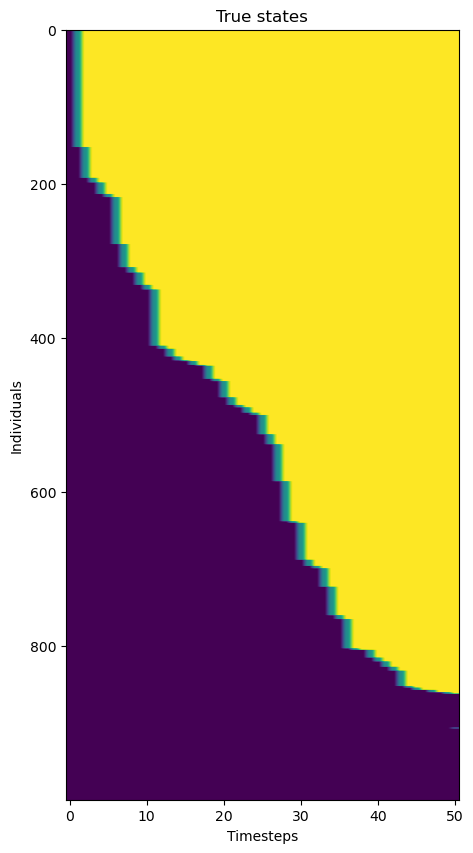

In [10]:
plt.figure(figsize = (7, 10))
plt.imshow(z[np.argsort(first_nonzero(z, axis=1)), :], aspect=.1)
plt.xlabel('Timesteps')
plt.ylabel('Individuals')
plt.title('True states')
plt.show()

## Simulate observations

At timesteps $t=1,..., T$ (but not $t=0$), surveys are conducted. Alive individuals are detected with probability $p_t$, and the recent dead are recovered with probability $\lambda_t$. We assume dead individuals are not detected. 

In [11]:
Omega = np.zeros((n_state, 3, n_tp1)) # (states, observations, timesteps)
for t in range(n_tp1):
    Omega[0, 0, t] = 1 - pr_detection[t]  # alive not detected
    Omega[0, 1, t] = pr_detection[t]      # alive and detected
    Omega[1, 0, t] = 1 - pr_recovery[t]   # recent dead, not recovered
    Omega[1, 2, t] = pr_recovery[t]       # recent dead, recovered
    Omega[2, 0, t] = 1                    # long-dead, never detected

In [12]:
y = np.zeros((initial_population_size, n_tp1))
for t in range(n_tp1):
    for i in range(initial_population_size):
        if (z[i, t] == 0):
            y[i, t] = np.random.binomial(1, pr_detection[t]) # y=1 --> detected
        if (z[i, t] == 1):
            recovered = np.random.binomial(1, pr_recovery[t])
            if recovered:
                y[i, t] = 2

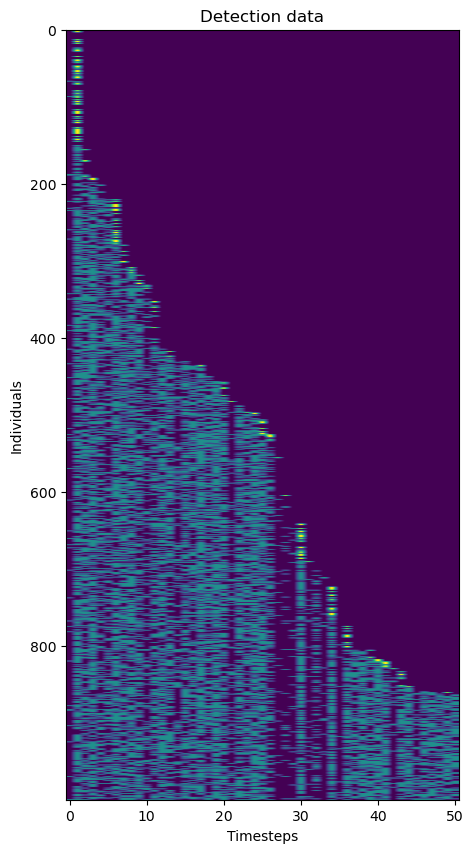

In [13]:
plt.figure(figsize = (7, 10))
plt.imshow(y[np.argsort(first_nonzero(z, axis=1)), :], aspect=.1)
plt.xlabel('Timesteps')
plt.ylabel('Individuals')
plt.title('Detection data')
plt.show()

## Build a neural network to map inputs to parameters

For this case study, one network template is used to construct three networks: one for survival, one for detection, and one for recovery.

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        output = torch.sigmoid(self.fc3(x))
        return output

In [15]:
net_survival = Net()
net_detection = Net()
net_recovery = Net()
running_loss = list()

## Create a data loader for the simulated data

In [16]:
x_tensor = torch.from_numpy(x_vals.astype(np.float32)).unsqueeze(-1)

In [17]:
y_tensor = torch.from_numpy(y.astype(np.int16))

In [18]:
dataset = TensorDataset(y_tensor)
    
dataloader = DataLoader(dataset, 
                        batch_size=64,
                        shuffle=True, 
                        num_workers=2)

## Define helper functions to compute the log-likelihood

In [19]:
def get_loglik(y, Gamma, Omega):
    """ Get log likelihood of a capture history w/ forward algorithm. """
    delta = torch.tensor([[1., 0., 0.]])
    prods = []
    running_prods = [torch.eye(n_state)]

    for t in range(1, n_tp1):
        running_prods.append(torch.mm(running_prods[t - 1], 
                                      torch.mm(Gamma[t - 1], 
                                               torch.diag(Omega[t, :, y[t]]))))
    return torch.sum(torch.mm(delta, running_prods[-1]))

## Train the models

The neural networks are trained simultaneously by passing the parameters for each to the same optimizer.

In [20]:
n_epoch = 100
optimizer = torch.optim.Adam(list(net_survival.parameters()) + 
                             list(net_detection.parameters()) + 
                             list(net_recovery.parameters()))

In [21]:
for i in tqdm(range(n_epoch)):
    for i_batch, y_batch in enumerate(dataloader):
        capture_histories = y_batch[0]
        optimizer.zero_grad()
        phi = net_survival(x_tensor)
        p_hat = net_detection(x_tensor)
        lamb = net_recovery(x_tensor)
        Gamma = torch.stack((torch.cat((phi, 1-phi, torch.zeros_like(phi)), 1), 
                             torch.tensor([0., 0., 1.]).expand(n_tp1, -1),
                             torch.tensor([0., 0., 1.]).expand(n_tp1, -1)), 
                            1)
        Omega = torch.stack((torch.cat((1 - p_hat, p_hat, torch.zeros_like(p_hat)), 1), 
                             torch.cat((1 - lamb, torch.zeros_like(lamb), lamb), 1),
                             torch.tensor([1., 0., 0.]).expand(n_tp1, -1)), 
                    1)        
        nlls = []
        for j in range(capture_histories.shape[0]):
            nlls.append(torch.log(get_loglik(capture_histories[j, :], Gamma, Omega)))
        nll = -torch.mean(torch.stack(nlls))
        nll.backward()
        optimizer.step()
        running_loss.append(nll.data.numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:12<00:00,  6.13s/it]


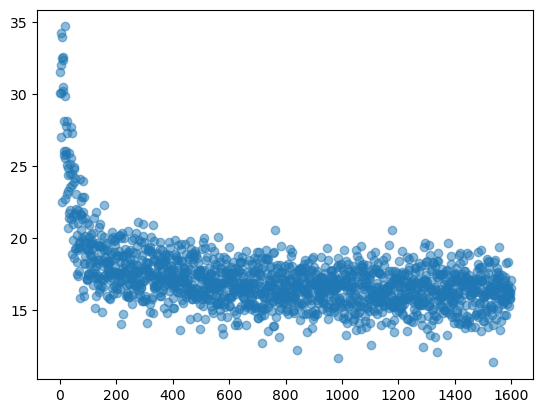

In [22]:
plt.scatter([i for i in range(len(running_loss))], 
             np.array(running_loss), 
            alpha=.5)

## Inspect estimated relationships between covariates and process parameters

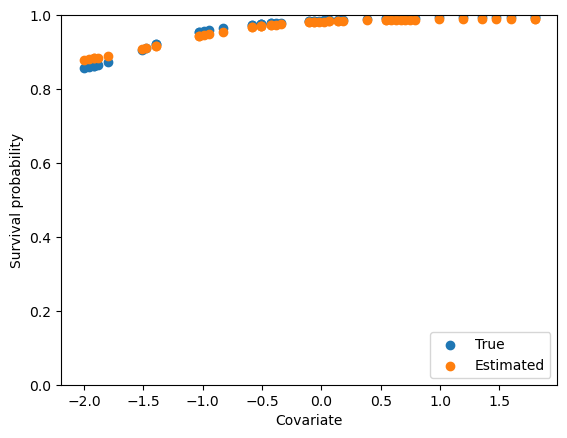

In [23]:
plt.scatter(x_vals, pr_survival)
plt.scatter(x_vals, phi[:, 0].detach().numpy())
plt.ylim(0, 1)
plt.legend(['True', 'Estimated'], loc = 'lower right')
plt.xlabel('Covariate')
plt.ylabel('Survival probability')
plt.show()

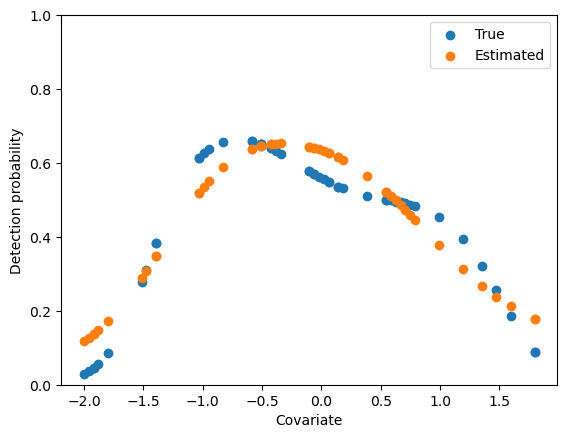

In [24]:
plt.scatter(x_vals, pr_detection)
plt.scatter(x_vals, p_hat[:, 0].detach().numpy())
plt.ylim(0, 1)
plt.legend(['True', 'Estimated'])
plt.xlabel('Covariate')
plt.ylabel('Detection probability')
plt.show()

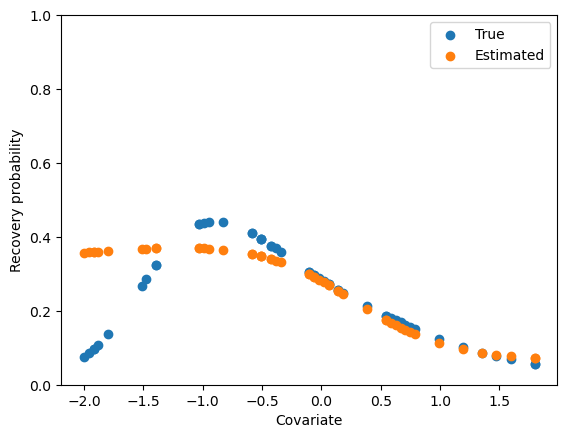

In [25]:
plt.scatter(x_vals, pr_recovery)
plt.scatter(x_vals, lamb[:, 0].detach().numpy())
plt.ylim(0, 1)
plt.legend(['True', 'Estimated'])
plt.xlabel('Covariate')
plt.ylabel('Recovery probability')
plt.show()